In [ ]:
import Pkg
Pkg.add("OpenDSSDirect")
Pkg.add("CSV")
Pkg.add("DataFrames")

In [ ]:
using OpenDSSDirect

basepath = joinpath(@__DIR__, "../data/Master_nando") # the goat
filename = joinpath(basepath, "Master.dss")

# dss is a short hand for text commands
dss("""
    clear
    compile "$filename"

    set VoltageBases=[22.0, 0.400, 0.2309]
    calcv
    
    set ControlMode=static
    reset

    Solve ! -- equivalent to solve snap
    """)

# Solution.SolveSnap()

# Proportional Allocation

In [ ]:
function ideal_oe_prop_exp_algorithm(
    names_active_cust, 
    active_cust_der_size,
    dss_engine
)
"""
Function to calculate the Ideal OE proportional allocation for exports in each time step.
This is used in all time steps of the day.    
:param names_active_cust: the list of active customers (Julia DataFrame)
:param active_cust_der_size: the size of active customers' DERs 
:param dss_engine: the OpenDSS engine
:return ideal_oe_prop_exp_values: the calculated ideal OE value for proportional allocation and exports
:return lv_tx_util: the transformer utilisation when using the calculated OE value
:return lv_hof_util_max: the maximum utilisation of the LV head of feeder when using the calculated OE value
:return volt_all_cust_temp: voltages on all customers when using the calculated OE value 
"""
    DSS = dss_engine

    # load LV network data from the OpenDSS model
    load_list = DSS.Loads.AllNames() # list of loads
    line_list = DSS.Lines.AllNames() # list of lines

    ### Check whether voltage limits have been breached
    
    max_voltage = 253
    oe_step_size = 0.5

    # must initialise variables outside of loop for variables to be stored
    flag_thermal_line = 1 
    flag_voltage = 1
    flag_thermal_tx = 1
    lv_tx_util = 0 
    lv_hof_util_max = 0 
    volt_all_cust_temp = [] 

    # lv_hof_util_f0 = 0
    # lv_hof_util_f1 = 0
    # lv_hof_util_f2 = 0

    alloc_exp_p_temp = active_cust_der_size[1] # allocated export power (temporarily set to a static 10 kw / can change according to different DER sizes)

    # iteratively run power flow calculations with reducing OE values until the point that no network limit (voltages or 
    # thermal) in any part of the LV network is breached.
    flag = 0 # flag to indicate when there is a technical problem (0 = problems; 1 = no problems)

    while flag==0

        for ild in range(1,nrow(names_active_cust))
            DSS.Circuit.SetActiveElement("load."*names_active_cust[!,1][ild]) # select an active customer
            temp = imag(DSS.CktElement.Powers()[1]) # save the current reactive power of the active customer
            DSS.Properties.Value("status","fixed") # fix the load status to run with the set value instead of profile
            DSS.Properties.Value("kW",string(-1*alloc_exp_p_temp)) # set the kW to the allocated OE value
            DSS.Properties.Value("kvar",string(temp)) # set the kvar to be the same as before
        end
        
        DSS.Solution.SolveSnap() # solve the power flow in OpenDSS without changing the time of the day

        # verify voltages on all customers
        
        # initialisation of variable to save voltage on all customers for the current OE value
        volt_all_cust_temp = [] 
        
        # collect the voltage from all customers
        for ild in range(1,length(load_list))
            DSS.Circuit.SetActiveElement("load."*string(load_list[ild])) # select a customer
            push!(volt_all_cust_temp, DSS.CktElement.VoltagesMagAng()[1]) # extract its voltage magnitude
        end
        
        # verify if the voltage of any of the customers is above the maximum statutory limit
        if maximum(volt_all_cust_temp) > max_voltage
            flag_voltage = 0 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
        else
            flag_voltage = 1 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
        end
        
        # initialise variables
        lv_hof_util_f0 = 0
        lv_hof_util_f1 = 0
        lv_hof_util_f2 = 0

        # verify each line for thermal issues
        for iline in range(1,length(line_list))
            DSS.Circuit.SetActiveElement("line."*string(line_list[iline])) # select a line

            currents = DSS.CktElement.CurrentsMagAng()
            
            # extract the current passing through the lines in phases A, B, and C
            Ia_line = maximum((currents[1],currents[7])) 
            Ib_line = maximum((currents[3],currents[9]))
            Ic_line = maximum((currents[5],currents[11]))
            
            # select the corresponding line
            DSS.Lines.Name(string(line_list[iline]))

            # extract the rated current of the corresponding line
            I_rated = DSS.Lines.NormAmps()
            
            # find the maximum per phase current passing through the line
            I_max_line_temp = maximum((Ia_line, Ib_line, Ic_line)) 
            
            # check if the line current is above the rated current of the corresponding line
            if I_max_line_temp > I_rated
                flag_thermal_line = 0 # flag to indicate when there is a thermal problem (0 = problems; 1 = no problems)
                break # in case any line has a thermal problem, the for loop stops (no need to check other lines) 
            else
                flag_thermal_line = 1 # flag to indicate when there is a thermal problem (0 = problems; 1 = no problems)
                # calculate the utilisation of the head of each feeder (there are 3 feeders in this LV network)
                if line_list[iline] == "hv_f0_lv28_f0_l0"
                    lv_hof_util_f0 = 100 * I_max_line_temp / I_rated
                elseif line_list[iline] == "hv_f0_lv28_f1_l0"
                    lv_hof_util_f1 = 100 * I_max_line_temp / I_rated
                elseif line_list[iline] == "hv_f0_lv28_f2_l0"
                    lv_hof_util_f2 = 100 * I_max_line_temp / I_rated
                end
            end
        end
        
        # keep the maximum utilisation on the head of feeder
        lv_hof_util_max = maximum((lv_hof_util_f0, lv_hof_util_f1, lv_hof_util_f2))

        # verify thermal limits of transformer
        
        # select the distribution transformer and extract rated voltage at the secondary
        DSS.Circuit.SetActiveElement("transformer.hv_f0_lv28_tx") 
        DSS.Transformers.Wdg(2.0) # select secondary winding (LV side)
        tx_rated_volt_sec = DSS.Transformers.kV() / sqrt(3) # Extract the transformer rated voltage at the secondary side
        
        # extract the distribution transformer rated power capacity
        tx_rated_power = parse(Float64, split(strip(DSS.Properties.Value("kVAs"), '['),", ")[1])

        # calculated distribution transformer current capacity (Amperes) per phase
        tx_amp_capacity_phase = (parse(Float64, split(strip(DSS.Properties.Value("kVAs"), '['),", ")[1]) 
                                / 3) / tx_rated_volt_sec 

        # extract the current passing through the distribution transformer for phases A, B, and C
        currents = DSS.CktElement.CurrentsMagAng()
        Ia_tx = currents[9]
        Ib_tx = currents[11]
        Ic_tx = currents[13]

        # check if the current passing through the distribution transformer is above the calculated current capacity
        if (Ia_tx + Ib_tx + Ic_tx) > (3 * tx_amp_capacity_phase)
            flag_thermal_tx = 0 # flag to indicate when there is a thermal problem (0 = problems; 1 = no problems)
        else
            flag_thermal_tx = 1 # flag to indicate when there is a thermal problem (0 = problems; 1 = no problems)
            lv_tx_util = 100 * (Ia_tx + Ib_tx + Ic_tx) / (3 * tx_amp_capacity_phase) # calculate the utilisation on the transformer
            # println(lv_tx_util)
        end

        # check if any technical isssue was found in the network           
        flag = flag_thermal_line * flag_voltage * flag_thermal_tx # flag to indicate when there is a technical problem (0 = problems; 1 = no problems)
        if flag == 0
            alloc_exp_p_temp -= oe_step_size # if above any limit, reduce the allocated OE by 0.5kW (pre-defined reduction step)
            
            # check if the OE has achieved the minimum possible OE value (zero)
            if alloc_exp_p_temp < 0
                alloc_exp_p_temp = 0 # if below zero, allocate zero as OE value
                break # voltage problems are still expected even after OE value is equal to zero. OE calculation finished.
            end
        end
    end

    ideal_oe_prop_exp_values = alloc_exp_p_temp # rename the allocated OE value

    # println(lv_hof_util_max)

    return ideal_oe_prop_exp_values, lv_tx_util, lv_hof_util_max, volt_all_cust_temp # return the calculated OE value for the export for the considered time step
end

### Run the Ideal OE Algorithm for the Day

In [ ]:
using OpenDSSDirect
using CSV
using DataFrames

const DFs = DataFrames
const DSS = OpenDSSDirect

# path to master file
basepath = joinpath(@__DIR__, "../data/Master_nando")
filename = joinpath(basepath, "Master.dss")

# define time resolution of the data
time_resolution = 5 # in minutes

# define number of time steps in the day (24h) for the corresponding time resolution
num_of_time_step = 288

dss("""
    clear
    compile "$filename"

    set VoltageBases=[22.0, 0.400, 0.2309]
    calcv
    
    set ControlMode=static
    reset

    set Mode=daily number=1 stepsize="$time_resolution"m
    """)

# load LV network data from the OpenDSS model
load_list = DSS.Loads.AllNames() # list of loads

basepath = joinpath(@__DIR__, "../data/day_30-15") # simulation files
active_cust = joinpath(basepath, "active_cust.csv")
tx_angles = joinpath(basepath, "tx_p_angles.csv")
tx_voltages = joinpath(basepath, "tx_p_voltages.csv")

# read in data for inputs
names_active_cust = CSV.File(active_cust) |> DFs.DataFrame # active customers in the network
active_cust_der_size = ones(nrow(names_active_cust)) * 10.0

# load voltage magnitudes and angles at the primary side of the distribution transformer which are affected by the 
# interactions with the upstream HV network (collected in another platform where the HV-LV network is fully modelled)
tx_pri_voltages_day = CSV.File(tx_voltages) |> DFs.DataFrame # voltage magnitudes
tx_pri_angles_day = CSV.File(tx_angles) |> DFs.DataFrame # voltage angles

# initialise arrays to save the OE values for each time step of the day
ideal_oe_prop_day_exp_values = zeros(nrow(names_active_cust),num_of_time_step)
ideal_oe_prop_day_exp_lv_tx_util = zeros(num_of_time_step)
ideal_oe_prop_day_exp_lv_hof_util_max = zeros(num_of_time_step)
ideal_oe_prop_day_exp_volt_all_cust = zeros(length(load_list), num_of_time_step)

# Calculate the OE values for each time step of the day in a for loop
for itime in range(1,num_of_time_step)
    # Set vsource with the distribution transformer voltage magnitudes and angles for the time step at the primary side
    temp1 = tx_pri_voltages_day[!,1][itime] / (22000 / sqrt(3))
    temp2 = tx_pri_angles_day[!,1][itime]
    temp3 = tx_pri_voltages_day[!,2][itime] / (22000 / sqrt(3))
    temp4 = tx_pri_angles_day[!,2][itime]
    temp5 = tx_pri_voltages_day[!,3][itime] / (22000 / sqrt(3))
    temp6 = tx_pri_angles_day[!,3][itime]

    dss("""
        edit vsource.source bus1=sourcebus.1 basekv=12.701706 pu="$temp1" angle="$temp2" phases=1
        edit vsource.source2 bus1=sourcebus.2 basekv=12.701706 pu="$temp3" angle="$temp4" phases=1
        edit vsource.source3 bus1=sourcebus.3 basekv=12.701706 pu="$temp5" angle="$temp6" phases=1
        """)

    DSS.Solution.SolveSnap() # solve the power flow in OpenDSS

    # call the ideal OE proportional allocation functions to calculate the OE value to each time step
    results = ideal_oe_prop_exp_algorithm(names_active_cust, active_cust_der_size, OpenDSSDirect) # export
    ideal_oe_prop_day_exp_values[:,itime]        .=results[1]
    ideal_oe_prop_day_exp_lv_tx_util[itime]       =results[2]
    ideal_oe_prop_day_exp_lv_hof_util_max[itime]  =results[3]
    ideal_oe_prop_day_exp_volt_all_cust[:, itime].=results[4]

    # print(results)

    # Reset active customers to profile values for the next time step
    default_kw_kvar = 1
    for ild in range(1,nrow(names_active_cust))
        DSS.Circuit.SetActiveElement("load."*string(names_active_cust[!,1][ild]))
        DSS.Properties.Value("status","variable")
        DSS.Properties.Value("kW",string(default_kw_kvar))
        DSS.Properties.Value("status",string(default_kw_kvar))
    end
end

# Check network-wide voltage compliance
valid_exp_voltage_lv_cust_10min = zeros(length(load_list), 144)
valid_exp_voltage_lv_cust_10min_sorted = zeros(length(load_list), 144)
cont_exp = 0
for ild in range(1,length(load_list))
    for i in range(1,144)
        valid_exp_voltage_lv_cust_10min[ild,i] = (ideal_oe_prop_day_exp_volt_all_cust[ild,2*i-1] + ideal_oe_prop_day_exp_volt_all_cust[ild,2*i]) / 2
    end
    valid_exp_voltage_lv_cust_10min_sorted[ild,:] = sort(valid_exp_voltage_lv_cust_10min[ild,:])
    if (valid_exp_voltage_lv_cust_10min_sorted[ild,143] > 253) || (valid_exp_voltage_lv_cust_10min_sorted[ild,2] < 216)
        cont_exp += 1
    end
end

exp_voltage_compliance = (1 - ((cont_exp) / length(load_list))) * 100

### Plotting OE exports

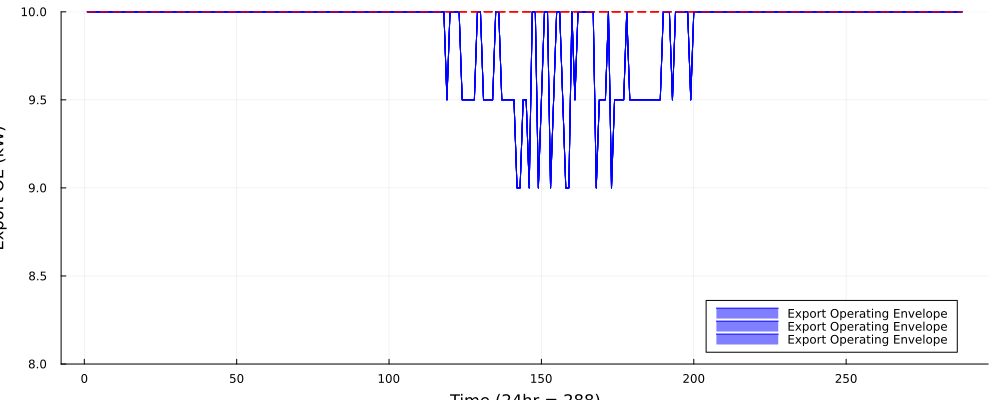

In [14]:
using Plots
# plot the calculated operating envelopes
x = range(1,num_of_time_step)
y1 = ideal_oe_prop_day_exp_values[13, :]
# y2 = ideal_oe_prop_day_imp_values * -1
y3 = ones(num_of_time_step) * 10
# y4 = np.ones(num_of_time_step) * -14

# plot!(x, y1, fillrange=y1, fillalpha=0.5, color="blue", label="Export Operating Envelope")
plot!(x, y1, color="blue", label=nothing, size=(1000,400))
# plot!(x, y2, fillrange=y2, fillalpha=0.5, color="green", label="Import Operating Envelope")
# plot!(x, y2, color="green", label=nothing)
plot!(x, y3, color="red", linestyle=:dash, label=nothing)
# plot!(x, y4, color="red", linestyle=:dash, label=nothing)

# Customize the plot
ylabel!("Export OE (kW)")
xlabel!("Time (24hr = 288)")
ylims!((8, 10))
